# Implementacja

#### Import bibliotek

In [146]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import _tree
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from rich.tree import Tree as RichTree
from rich import print
from IPython.display import clear_output
from rich.console import Console
import json
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

#### Implementacja drzewa

In [ ]:
class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, similarity_threshold=0.01, preference_list=None,
                 interactive=False, interactive_threshold=0.01, random_state=None,
                 min_samples_split=2, feature_names=None, class_names=None):
        self.max_depth = max_depth
        self.similarity_threshold = similarity_threshold
        self.preference_list = preference_list or []
        self.interactive = interactive
        self.interactive_threshold = interactive_threshold
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.tree_ = None
        self.class_names = class_names
        self.feature_types = None
        self.console = Console()
        self.feature_names = feature_names

    def _calculate_split_quality(self, X, y, feature_index):
        values = X[:, feature_index]
        mode = self.feature_types[feature_index]
        if mode == 'categorical':
            unique_values = np.unique(values)
            splits = [y[values == val] for val in unique_values]
            weighted_gini = sum(
                len(s) / len(y) * (1 - sum((np.mean(s == c) ** 2 for c in np.unique(s))))
                for s in splits
            )
            return -weighted_gini, None

        elif mode == 'continuous':
            sorted_idx = np.argsort(values)
            values_sorted, y_sorted = values[sorted_idx], y[sorted_idx]

            best_gini = float('inf')
            best_threshold = None

            for i in range(1, len(values_sorted)):
                if values_sorted[i] == values_sorted[i - 1]:
                    continue
                threshold = (values_sorted[i] + values_sorted[i - 1]) / 2
                left_y = y_sorted[values_sorted < threshold]
                right_y = y_sorted[values_sorted >= threshold]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                gini_left = 1.0 - sum((np.mean(left_y == c) ** 2 for c in np.unique(y)))
                gini_right = 1.0 - sum((np.mean(right_y == c) ** 2 for c in np.unique(y)))
                weighted_gini = (len(left_y) * gini_left + len(right_y) * gini_right) / len(y)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_threshold = threshold

            return -best_gini, best_threshold

    def _choose_split(self, qualities, highlight_path):
        best_quality = qualities[0][1]
        candidates = [q for q in qualities if abs(q[1] - best_quality) <= self.similarity_threshold]

        if self.interactive and abs(candidates[0][1] - candidates[-1][1]) <= self.interactive_threshold:
            clear_output(wait=True)
            self.console.print("[bold cyan]Tree now (> - node to insert):[/bold cyan]")
            self.console.print(self.to_rich(self.tree_, highlight_path=highlight_path))

            self.console.print("\n[bold yellow]Close quality, choose one:[/bold yellow]")

            lines = []
            for idx, (f, q) in enumerate(candidates):
                feature_name = self.feature_names[f] if self.feature_names else f"Feature {f}"
                lines.append(f"[bold blue]{idx}[/bold blue]: Feature [cyan]{feature_name}[/cyan] (Quality: [green]{q:.4f}[/green])")

            self.console.print("\n".join(lines))

            try:
                choice = int(input("Choose feature index: "))
                if choice < 0 or choice >= len(candidates):
                    print("Wrong choice, using first candidate.")
                    choice = 0
            except ValueError:
                print("Wrong input, using first candidate.")
                choice = 0
            return candidates[choice][0]

        if self.preference_list:
            candidate_features = {f for f, _ in candidates}
            for preferred in self.preference_list:
                if preferred in candidate_features:
                    return preferred

        return candidates[0][0]

    def _build_tree(self, X, y, depth=0, used_features=None, path=None, parent=None, val_from_parent=None):
        if used_features is None:
            used_features = set()
        if path is None:
            path = []

        if (self.max_depth is not None and depth >= self.max_depth) or len(set(y)) == 1 or \
        len(y) < self.min_samples_split or len(used_features) == X.shape[1]:
            leaf = {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }
            if parent is not None and val_from_parent is not None:
                parent['branches'][val_from_parent] = leaf
            return leaf

        qualities = []
        thresholds = {}
        for i in range(X.shape[1]):
            if i in used_features:
                continue
            quality, threshold = self._calculate_split_quality(X, y, i)
            qualities.append((i, quality))
            thresholds[i] = threshold

        if not qualities:
            leaf = {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }
            if parent is not None and val_from_parent is not None:
                parent['branches'][val_from_parent] = leaf
            return leaf

        qualities.sort(key=lambda x: -x[1])
        feature = self._choose_split(qualities, path)
        threshold = thresholds[feature]
        new_used_features = used_features.copy()
        new_used_features.add(feature)
        default_class = np.bincount(y).argmax()

        node = {
            'type': 'split',
            'feature': feature,
            'threshold': threshold,
            'branches': {},
            'default_class': default_class
        }

        if parent is not None and val_from_parent is not None:
            parent['branches'][val_from_parent] = node
        else:
            self.tree_ = node

        if self.feature_types[feature] == 'categorical':
            values = np.unique(X[:, feature])
            for val in values:
                idx = X[:, feature] == val
                if np.sum(idx) == 0:
                    continue
                node['branches'][val] = {'type': 'pending'}
                self._build_tree(
                    X[idx], y[idx],
                    depth=depth + 1,
                    used_features=new_used_features,
                    path=path + [(feature, val)],
                    parent=node,
                    val_from_parent=val
                )

        elif self.feature_types[feature] == 'continuous':
            idx_left = X[:, feature] < threshold
            idx_right = X[:, feature] >= threshold
            node['branches']['left'] = {'type': 'pending'}
            node['branches']['right'] = {'type': 'pending'}

            self._build_tree(
                X[idx_left], y[idx_left],
                depth=depth + 1,
                used_features=new_used_features,
                path=path + [(feature, 'left')],
                parent=node,
                val_from_parent='left'
            )

            self._build_tree(
                X[idx_right], y[idx_right],
                depth=depth + 1,
                used_features=new_used_features,
                path=path + [(feature, 'right')],
                parent=node,
                val_from_parent='right'
            )

        return node

    def fit(self, X, y):
        X_arr, y_arr = np.array(X), np.array(y)
        if self.feature_names is None:
            self.feature_names = X.columns.tolist() if hasattr(X, 'columns') else [f"Feature {i}" for i in range(X.shape[1])]
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()
            self.feature_types = self._infer_feature_types(X)
        else:
            self.feature_names = [f"Feature {i}" for i in range(X.shape[1])]
            self.feature_types = ['continuous'] * X.shape[1]
        self.tree_ = self._build_tree(X_arr, y_arr)
        clear_output(wait=True)
        return self

    def _infer_feature_types(self, X):
        types = []
        for col in X.columns:
            if X[col].dtype == 'object' or X[col].dtype.name == 'category':
                types.append('categorical')
            elif pd.api.types.is_numeric_dtype(X[col]):
                # opcjonalnie można dodać heurystykę np. liczba unikalnych wartości
                if X[col].nunique() < 10:  # np. 10 lub inny próg
                    types.append('categorical')
                else:
                    types.append('continuous')
            else:
                types.append('categorical')  # domyślnie
        return types

    def _predict_sample(self, x, node):
        if node['type'] == 'leaf':
            return node['class']

        val = x[node['feature']]
        if self.feature_types[node['feature']] == 'categorical':
            branch = node['branches'].get(val)
        else:  # inequality
            branch = node['branches']['left'] if val < node['threshold'] else node['branches']['right']

        if branch is None:
            return node.get('default_class', 0)
        return self._predict_sample(x, branch)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree_) for x in X.to_numpy()])

    def predict_proba(self, X):
        def _predict_proba_sample(x, node):
            if node['type'] == 'leaf':
                counts = np.zeros(2)
                total = sum(node.get('label_counts', [0]))
                if total > 0:
                    counts[:len(node['label_counts'])] = node['label_counts']
                    return counts / total
                else:
                    return np.array([0.5, 0.5])
            val = x[node['feature']]
            if self.feature_types[node['feature']] == 'categorical':
                branch = node['branches'].get(val)
            else:
                branch = node['branches']['left'] if val < node['threshold'] else node['branches']['right']
            if branch is None:
                return np.array([0.5, 0.5])
            return _predict_proba_sample(x, branch)

        return np.array([_predict_proba_sample(x, self.tree_) for x in X.to_numpy()])

    def to_rich(self, node=None, highlight_path=None):
        if node is None:
            node = self.tree_
        if highlight_path is None:
            highlight_path = []

        def build_tree(node, path_so_far):
            if node is None:
                return RichTree("[red]No data[/red]")

            is_highlight = path_so_far == highlight_path

            if node.get('type') == 'pending':
                label = "[magenta]Building...[/magenta]"
                if is_highlight:
                    label = f"[bold red]> {label}[/bold red]"
                return RichTree(label)

            if node['type'] == 'leaf':
                cls = node['class']
                class_label = self.class_names[cls] if self.class_names else f"Class {cls}"
                label = f"[green]{class_label}[/green]"
                if is_highlight:
                    label = f"[bold red]> {label}[/bold red]"
                return RichTree(label)

            feature_name = self.feature_names[node['feature']] if self.feature_names else f"Feature {node['feature']}"
            label = f"[cyan]{feature_name}[/cyan]"
            if self.feature_types[node['feature']] == 'continuous' and node.get('threshold') is not None:
                label += f" [white]< {node['threshold']:.2f}[/white]"
            if is_highlight:
                label = f"[bold red]> {label}[/bold red]"
            tree = RichTree(label)

            for val, child in node['branches'].items():
                new_path = path_so_far + [(node['feature'], val)]
                branch_label = f"[yellow]{val}[/yellow]"
                subtree = build_tree(child, new_path)
                tree.add(branch_label).children.append(subtree)
            return tree

        return build_tree(node, [])


#### Evaluate model

In [148]:
def train_and_evaluate_model(model, X, y, target_names=None, test_size=0.2, random_state=42):
    # Data split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_micro = f1_score(y_val, y_pred, average='micro')
    cm = confusion_matrix(y_val, y_pred)
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    console = Console()
    console.print(
        f"Accuracy: {acc:.4f}\n"
        f"F1 Score (macro): {f1_macro:.4f}\n"
        f"F1 Score (micro): {f1_micro:.4f}\n"
        f"Confusion Matrix:\n{df_cm}"
    )

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # ROC + AUC only for binary classification
    if len(np.unique(y_val)) == 2:
        y_scores = model.predict_proba(X_val)[:, 1]

        fpr, tpr, _ = roc_curve(y_val, y_scores)
        roc_auc = auc(fpr, tpr)
        
        console.print(f"AUC: {roc_auc:.4f}")
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.title("ROC Curve")
        plt.show()
    else:
        console.print("ROC + AUC only for binary classification.")
    
    metrics = {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro
    }
    return metrics, df_cm

def evaluate_model(model, X, y, target_names=None):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    cm = confusion_matrix(y, y_pred)
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    console = Console()
    console.print(
        f"Accuracy: {acc:.4f}\n"
        f"F1 Score (macro): {f1_macro:.4f}\n"
        f"F1 Score (micro): {f1_micro:.4f}\n"
        f"Confusion Matrix:\n{df_cm}"
    )

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    metrics = {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro
    }
    return metrics, df_cm

#### Przykład wywołania (preferencje)

Accuracy: 0.9618
F1 Score (macro): 0.9618
F1 Score (micro): 0.9618
Confusion Matrix:
           edible  poisonous
edible        816         26
poisonous      36        747

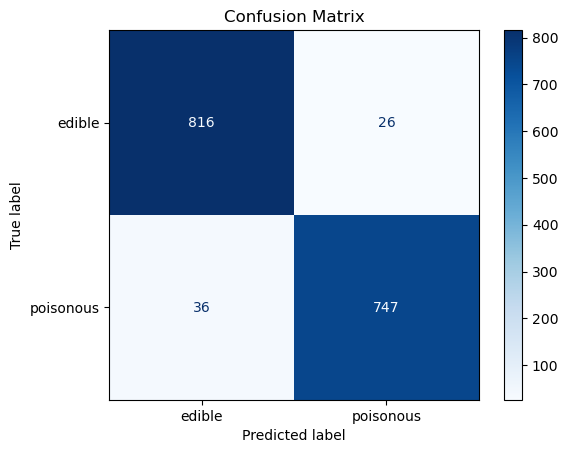

AUC: 0.9933

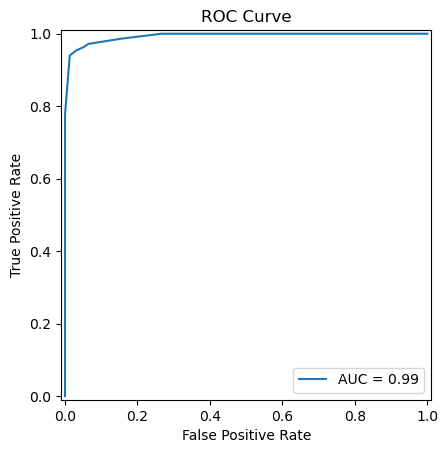

> habitat
├── 0
│   └── population
│       ├── 1
│       │   └── poisonous
│       ├── 3
│       │   └── poisonous
│       ├── 4
│       │   └── spore-print-color
│       │       ├── 1
│       │       │   └── ring-type
│       │       │       ├── 1
│       │       │       │   └── edible
│       │       │       └── 2
│       │       │           └── poisonous
│       │       ├── 2
│       │       │   └── ring-type
│       │       │       └── 4
│       │       │           └── edible
│       │       ├── 3
│       │       │   └── ring-type
│       │       │       └── 4
│       │       │           └── edible
│       │       ├── 6
│       │       │   └── edible
│       │       └── 7
│       │           └── poisonous
│       └── 5
│           └── spore-print-color
│               ├── 1
│               │   └── ring-type
│               │       ├── 1
│               │       │   └── edible
│               │       └── 2
│               │           └── poisonous
│               ├── 2
│               │   └── edible
│               ├── 3
│               │   └── edible
│               └── 7
│                   └── edible
├── 1
│   └── population
│       ├── 0
│       │   └── edible
│       ├── 2
│       │   └── edible
│       ├── 3
│       │   └── spore-print-color
│       │       ├── 1
│       │       │   └── poisonous
│       │       ├── 2
│       │       │   └── ring-type
│       │       │       ├── 0
│       │       │       │   └── edible
│       │       │       └── 4
│       │       │           └── edible
│       │       ├── 3
│       │       │   └── ring-type
│       │       │       ├── 0
│       │       │       │   └── edible
│       │       │       └── 4
│       │       │           └── edible
│       │       └── 7
│       │           └── edible
│       ├── 4
│       │   └── poisonous
│       └── 5
│           └── spore-print-color
│               ├── 1
│               │   └── poisonous
│               ├── 2
│               │   └── edible
│               └── 3
│                   └── edible
├── 2
│   └── population
│       ├── 1
│       │   └── spore-print-color
│       │       ├── 0
│       │       │   └── edible
│       │       ├── 3
│       │       │   └── edible
│       │       ├── 4
│       │       │   └── edible
│       │       ├── 7
│       │       │   └── poisonous
│       │       └── 8
│       │           └── edible
│       └── 4
│           └── spore-print-color
│               ├── 0
│               │   └── edible
│               ├── 3
│               │   └── edible
│               ├── 4
│               │   └── edible
│               ├── 7
│               │   └── ring-type
│               │       └── 0
│               │           └── poisonous
│               └── 8
│                   └── edible
├── 3
│   └── population
│       ├── 2
│       │   └── edible
│       ├── 3
│       │   └── edible
│       └── 4
│           └── poisonous
├── 4
│   └── population
│       ├── 3
│       │   └── edible
│       ├── 4
│       │   └── spore-print-color
│       │       ├── 1
│       │       │   └── poisonous
│       │       └── 7
│       │           └── ring-type
│       │               ├── 0
│       │               │   └── poisonous
│       │               └── 4
│       │                   └── edible
│       └── 5
│           └── spore-print-color
│               ├── 1
│               │   └── poisonous
│               ├── 2
│               │   └── edible
│               ├── 3
│               │   └── edible
│               └── 7
│                   └── edible
├── 5
│   └── population
│       ├── 3
│       │   └── poisonous
│       ├── 4
│       │   └── spore-print-color
│       │       ├── 1
│       │       │   └── poisonous
│       │       ├── 2
│       │       │   └── ring-type
│       │       │       └── 4
│       │       │           └── poisonous
│       │       └── 3
│       │           └── ring-type
│       │               └── 4
│       │                   └── poisonous
│       └── 5
│           └── edible
└── 6
    └── edible

In [149]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5, class_names=["edible", "poisonous"])
                                   
train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=3928, target_names=["edible", "poisonous"])
console = Console()
console.print(clf.to_rich())


#### Przykład wywołania (interaktywny)

Accuracy: 0.9865
F1 Score (macro): 0.9864
F1 Score (micro): 0.9865
Confusion Matrix:
           edible  poisonous
edible        829         13
poisonous       9        774

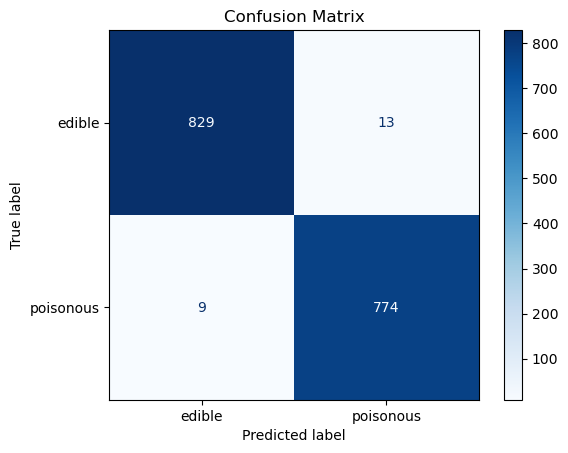

> habitat
├── 0
│   └── population
│       ├── 1
│       │   └── poisonous
│       ├── 3
│       │   └── poisonous
│       ├── 4
│       │   └── spore-print-color
│       │       ├── 1
│       │       │   └── stalk-root
│       │       │       ├── 0
│       │       │       │   └── poisonous
│       │       │       └── 4
│       │       │           └── edible
│       │       ├── 2
│       │       │   └── stalk-shape
│       │       │       ├── 0
│       │       │       │   └── poisonous
│       │       │       └── 1
│       │       │           └── edible
│       │       ├── 3
│       │       │   └── stalk-shape
│       │       │       ├── 0
│       │       │       │   └── poisonous
│       │       │       └── 1
│       │       │           └── edible
│       │       ├── 6
│       │       │   └── edible
│       │       └── 7
│       │           └── poisonous
│       └── 5
│           └── spore-print-color
│               ├── 1
│               │   └── gill-size
│               │       ├── 0
│               │       │   └── poisonous
│               │       └── 1
│               │           └── edible
│               ├── 2
│               │   └── edible
│               ├── 3
│               │   └── edible
│               └── 7
│                   └── edible
├── 1
│   └── population
│       ├── 0
│       │   └── edible
│       ├── 2
│       │   └── edible
│       ├── 3
│       │   └── spore-print-color
│       │       ├── 1
│       │       │   └── poisonous
│       │       ├── 2
│       │       │   └── bruises%3F
│       │       │       ├── 0
│       │       │       │   └── edible
│       │       │       └── 1
│       │       │           └── edible
│       │       ├── 3
│       │       │   └── gill-spacing
│       │       │       ├── 0
│       │       │       │   └── edible
│       │       │       └── 1
│       │       │           └── edible
│       │       └── 7
│       │           └── edible
│       ├── 4
│       │   └── poisonous
│       └── 5
│           └── spore-print-color
│               ├── 1
│               │   └── poisonous
│               ├── 2
│               │   └── edible
│               └── 3
│                   └── edible
├── 2
│   └── population
│       ├── 1
│       │   └── spore-print-color
│       │       ├── 0
│       │       │   └── edible
│       │       ├── 3
│       │       │   └── edible
│       │       ├── 4
│       │       │   └── edible
│       │       ├── 7
│       │       │   └── poisonous
│       │       └── 8
│       │           └── edible
│       └── 4
│           └── spore-print-color
│               ├── 0
│               │   └── edible
│               ├── 3
│               │   └── edible
│               ├── 4
│               │   └── edible
│               ├── 7
│               │   └── gill-color < 5.00
│               │       ├── left
│               │       │   └── poisonous
│               │       └── right
│               │           └── edible
│               └── 8
│                   └── edible
├── 3
│   └── stalk-root
│       ├── 0
│       │   └── poisonous
│       └── 1
│           └── edible
├── 4
│   └── bruises%3F
│       ├── 0
│       │   └── gill-color < 8.50
│       │       ├── left
│       │       │   └── poisonous
│       │       └── right
│       │           └── edible
│       └── 1
│           └── edible
├── 5
│   └── population
│       ├── 3
│       │   └── poisonous
│       ├── 4
│       │   └── spore-print-color
│       │       ├── 1
│       │       │   └── poisonous
│       │       ├── 2
│       │       │   └── ring-type
│       │       │       └── 4
│       │       │           └── poisonous
│       │       └── 3
│       │           └── ring-type
│       │               └── 4
│       │                   └── poisonous
│       └── 5
│           └── edible
└── 6
    └── edible

In [185]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=3131, stratify=y
)
feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5,
                                   interactive=True,
                                   interactive_threshold=0.25, class_names=["edible", "poisonous"])
clf.fit(X_train, y_train)
evaluate_model(clf, X_val, y_val, target_names=["edible", "poisonous"])
console = Console()
console.print(clf.to_rich())

# Testy i eksperymenty

## Zbiory danych

In [151]:
metrics = {}

### Mushroom

In [152]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
metrics["Mushroom"] = {}
RANDOM_STATE = 3928

#### 0) Podstawowy klasyfikator (brak preferencji)


Accuracy: 1.0000
F1 Score (macro): 1.0000
F1 Score (micro): 1.0000
Confusion Matrix:
           edible  poisonous
edible        842          0
poisonous       0        783

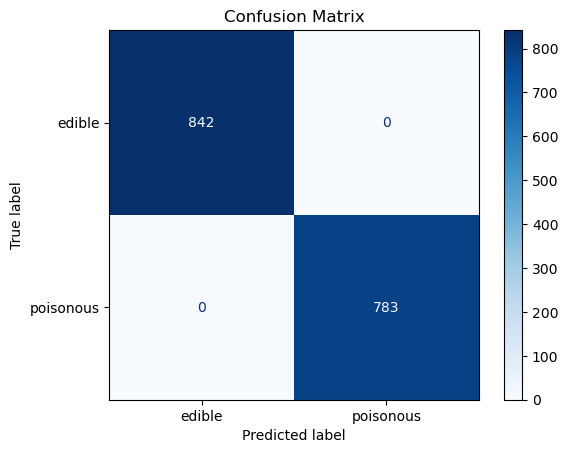

AUC: 1.0000

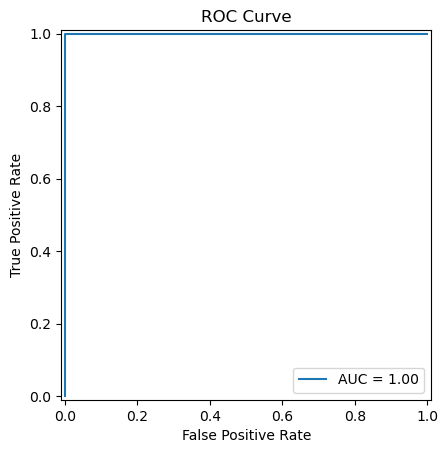

In [153]:
clf = CustomDecisionTreeClassifier(
    preference_list=[],
    similarity_threshold=0.0,
    max_depth=5,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["0"] = (met, cm)

#### a) Preferowane atrybuty o niewielkiej liczbie wartości

Accuracy: 0.8917
F1 Score (macro): 0.8908
F1 Score (micro): 0.8917
Confusion Matrix:
           edible  poisonous
edible        799         43
poisonous     133        650

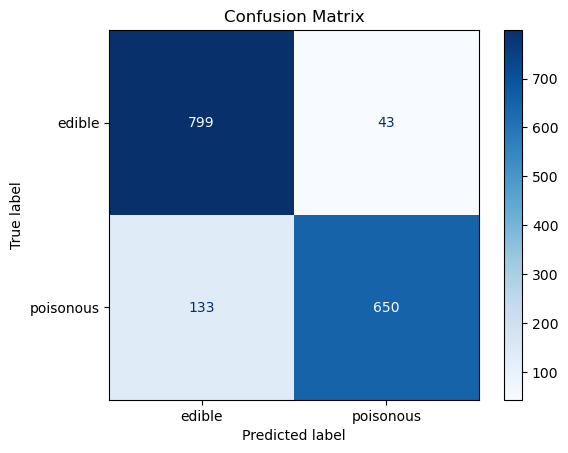

AUC: 0.9062

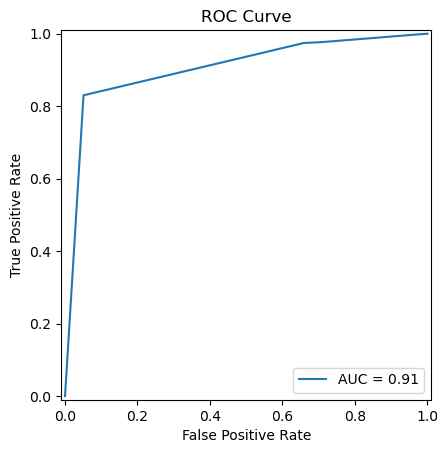

Feature order:
[
    'veil-type',
    'bruises%3F',
    'gill-attachment',
    'gill-spacing',
    'gill-size',
    'stalk-shape',
    'ring-number',
    'cap-surface',
    'veil-color',
    'stalk-surface-above-ring',
    'stalk-surface-below-ring',
    'stalk-root',
    'ring-type',
    'cap-shape',
    'population',
    'habitat',
    'stalk-color-below-ring',
    'odor',
    'spore-print-color',
    'stalk-color-above-ring',
    'cap-color',
    'gill-color'
]

In [154]:
feature_cardinality = X.nunique()
sorted_features = feature_cardinality.sort_values().index.tolist()
feature_order = [X.columns.get_loc(col) for col in sorted_features]

clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["a"] = (met, cm)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### b) Preferowane atrybuty ustalone przez analizę danych

Accuracy: 0.9938
F1 Score (macro): 0.9938
F1 Score (micro): 0.9938
Confusion Matrix:
           edible  poisonous
edible        842          0
poisonous      10        773

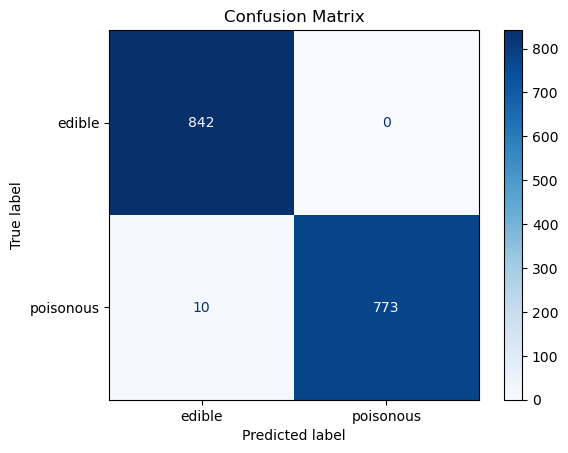

AUC: 0.9996

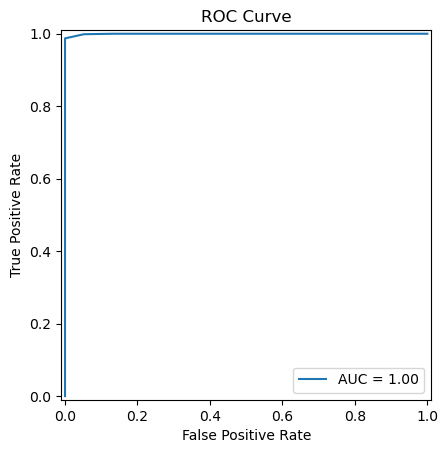

Feature order:
[
    'odor',
    'spore-print-color',
    'gill-color',
    'ring-type',
    'stalk-surface-above-ring',
    'stalk-surface-below-ring',
    'stalk-color-above-ring',
    'stalk-color-below-ring',
    'gill-size',
    'bruises%3F',
    'population',
    'habitat',
    'stalk-root',
    'gill-spacing',
    'cap-shape',
    'ring-number',
    'cap-surface',
    'cap-color',
    'veil-color',
    'gill-attachment',
    'stalk-shape',
    'veil-type'
]

In [155]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X, y, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}

sorted_features = sorted(feature_scores.items(), key=lambda x: -x[1])
feature_order = [X.columns.get_loc(col) for col, _ in sorted_features]

clf_b = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)

met_b, cm_b = train_and_evaluate_model(clf_b, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["b"] = (met_b, cm_b)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

Accuracy: 0.9914
F1 Score (macro): 0.9914
F1 Score (micro): 0.9914
Confusion Matrix:
           edible  poisonous
edible        842          0
poisonous      14        769

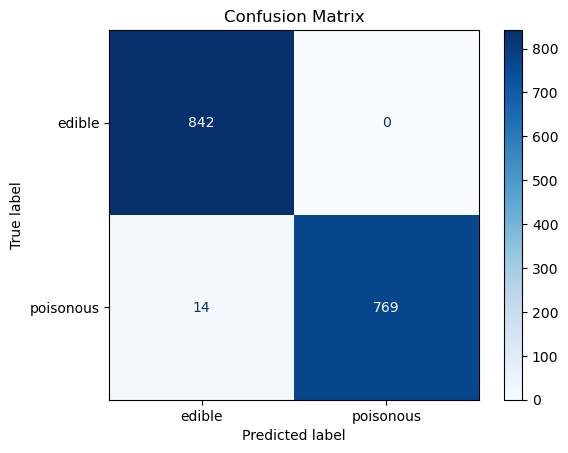

AUC: 0.9971

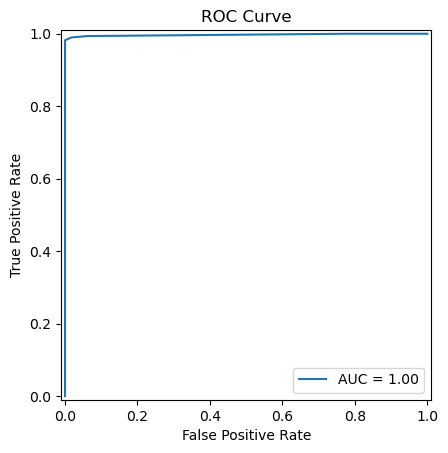

Feature order:
['odor', 'cap-color', 'gill-size', 'gill-color']

In [156]:
preferred_features = ['odor', 'cap-color', 'gill-size', 'gill-color']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["c"] = (met, cm)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### d) Unikanie atrybutów zawierających szum

Accuracy: 0.9065
F1 Score (macro): 0.9064
F1 Score (micro): 0.9065
Confusion Matrix:
           edible  poisonous
edible        750         92
poisonous      60        723

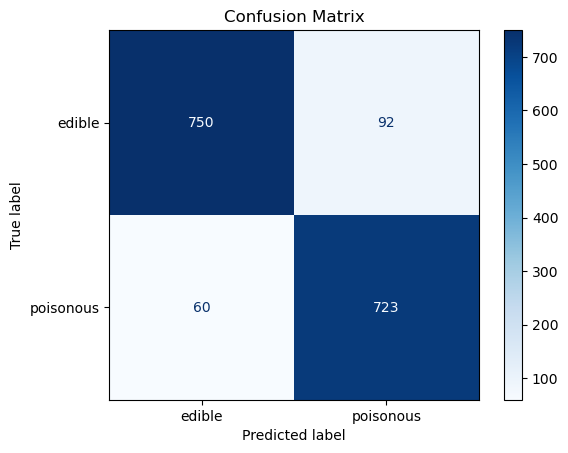

AUC: 0.9362

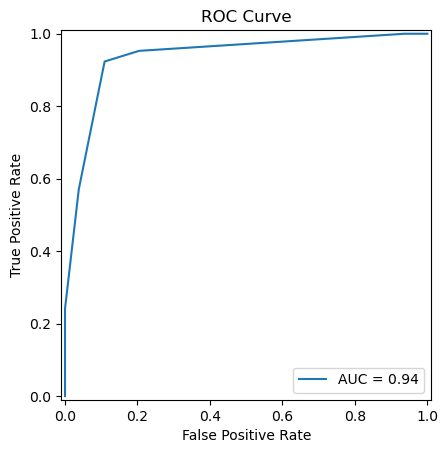

Feature order:
[
    'odor',
    'spore-print-color',
    'gill-color',
    'ring-type',
    'stalk-surface-above-ring',
    'stalk-surface-below-ring',
    'stalk-color-above-ring',
    'stalk-color-below-ring',
    'gill-size',
    'bruises%3F',
    'population',
    'habitat',
    'stalk-root',
    'gill-spacing',
    'cap-shape',
    'ring-number',
    'cap-surface',
    'cap-color',
    'veil-color',
    'gill-attachment'
]

In [157]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}

threshold = 0.01 

filtered_features = [(col, score) for col, score in feature_scores.items() if score > threshold]
feature_order = [X.columns.get_loc(col) for col, _ in sorted(filtered_features, key=lambda x: -x[1])]

clf_d = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)

met_d, cm_d = train_and_evaluate_model(clf_d, X.iloc[:, feature_order], y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["d"] = (met_d, cm_d)

feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### e) Preferencje na podstawie logicznej istotności

Accuracy: 0.9969
F1 Score (macro): 0.9969
F1 Score (micro): 0.9969
Confusion Matrix:
           edible  poisonous
edible        839          3
poisonous       2        781

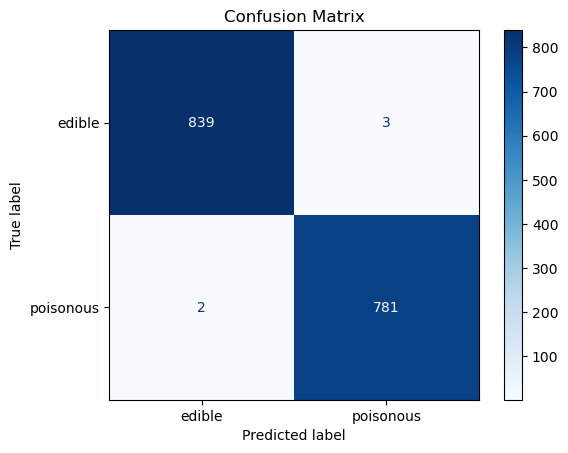

AUC: 1.0000

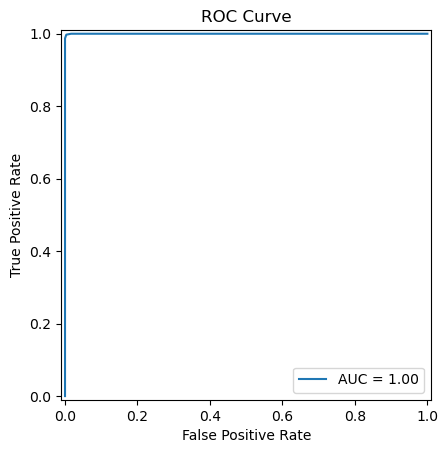

Feature order:
['odor', 'spore-print-color', 'gill-color']

In [158]:
preferred_features = ['odor', 'spore-print-color', 'gill-color']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["e"] = (met, cm)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### Porównanie podejść

In [159]:
rows = []
for key in metrics["Mushroom"]:
    scores, cm = metrics["Mushroom"][key]
    fn = cm.loc["edible", "poisonous"]
    fp = cm.loc["poisonous", "edible"]
    total_errors = fn + fp
    rows.append({
        "Experiment": key,
        "Accuracy": round(scores["accuracy"], 4),
        "F1 Macro": round(scores["f1_macro"], 4),
        "F1 Micro": round(scores["f1_micro"], 4),
        "Total errors (FP+FN)": total_errors
    })

df = pd.DataFrame(rows).sort_values(by="Experiment")
print(df.to_string(index=False))

Experiment  Accuracy  F1 Macro  F1 Micro  Total errors (FP+FN)
         0    1.0000    1.0000    1.0000                     0
         a    0.8917    0.8908    0.8917                   176
         b    0.9938    0.9938    0.9938                    10
         c    0.9914    0.9914    0.9914                    14
         d    0.9065    0.9064    0.9065                   152
         e    0.9969    0.9969    0.9969                     5

### Wine Quality

In [160]:
wine_quality = fetch_ucirepo(id=186) 
  
X = wine_quality.data.features 
y = wine_quality.data.targets
print(y)

y = y.values.ravel()
y = (y >= 6).astype(int)
X = X.copy()
metrics["Wine"] = {}
RANDOM_STATE = 3928

quality
0           5
1           5
2           5
3           6
4           5
...       ...
6492        6
6493        5
6494        6
6495        7
6496        6

[6497 rows x 1 columns]

#### 0) Podstawowy klasyfikator (brak preferencji)


Accuracy: 0.7423
F1 Score (macro): 0.7228
F1 Score (micro): 0.7423
Confusion Matrix:
      bad  good
bad   310   167
good  168   655

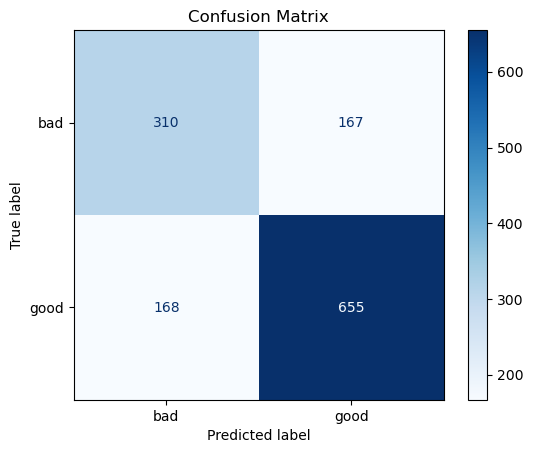

AUC: 0.7888

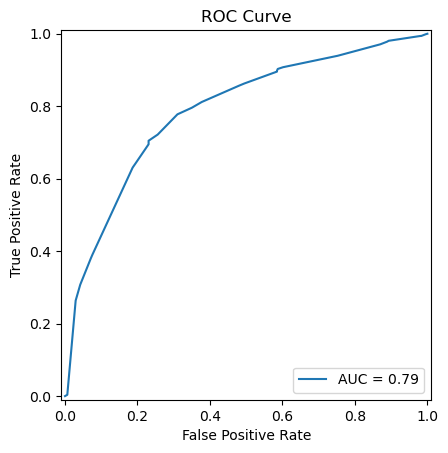

In [161]:
clf = CustomDecisionTreeClassifier(
    preference_list=[],
    similarity_threshold=0.0,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["0"] = (met, cm)

#### a) Preferowane atrybuty o niewielkiej liczbie wartości

Accuracy: 0.6954
F1 Score (macro): 0.6547
F1 Score (micro): 0.6954
Confusion Matrix:
      bad  good
bad   229   248
good  148   675

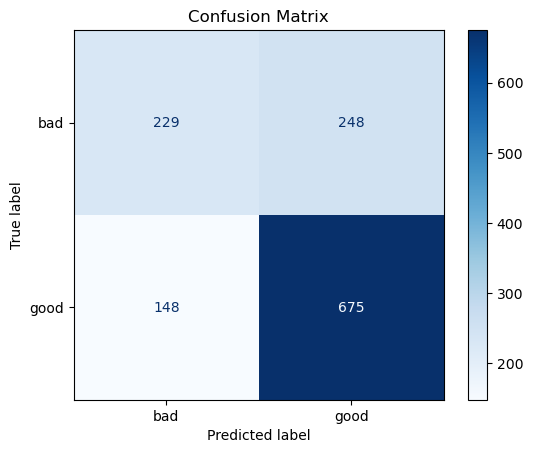

AUC: 0.7445

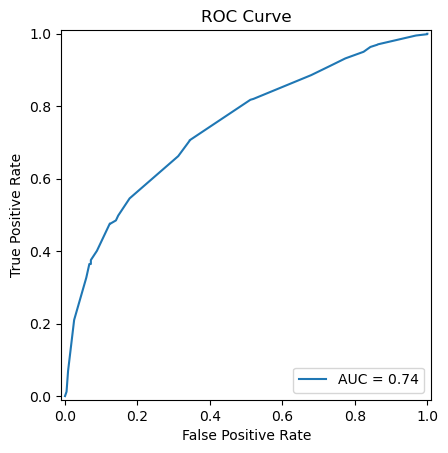

Feature order:
[
    'citric_acid',
    'fixed_acidity',
    'pH',
    'sulphates',
    'alcohol',
    'free_sulfur_dioxide',
    'volatile_acidity',
    'chlorides',
    'total_sulfur_dioxide',
    'residual_sugar',
    'density'
]

In [162]:
feature_cardinality = X.nunique()
sorted_features = feature_cardinality.sort_values().index.tolist()
feature_order = [X.columns.get_loc(col) for col in sorted_features]

clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["a"] = (met, cm)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### b) Preferowane atrybuty ustalone przez analizę danych

Accuracy: 0.7300
F1 Score (macro): 0.6938
F1 Score (micro): 0.7300
Confusion Matrix:
      bad  good
bad   251   226
good  125   698

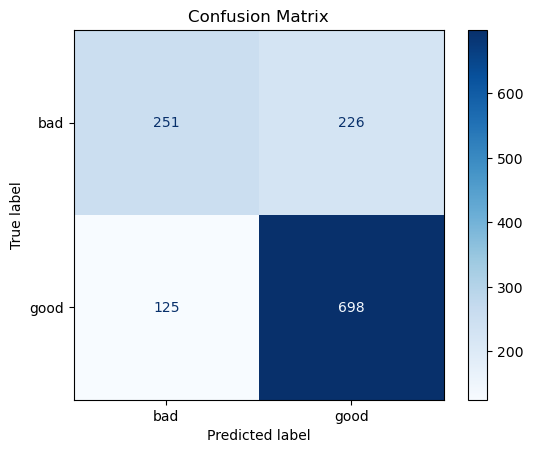

AUC: 0.7737

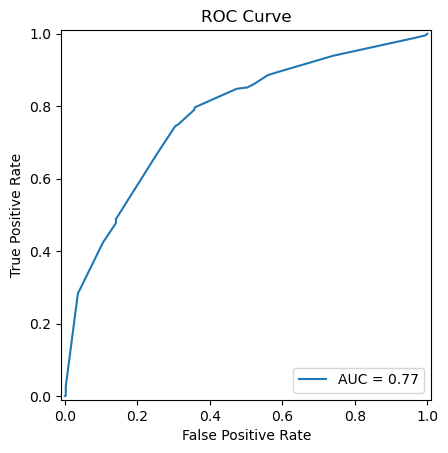

Feature order:
[
    'alcohol',
    'density',
    'volatile_acidity',
    'chlorides',
    'citric_acid',
    'total_sulfur_dioxide',
    'residual_sugar',
    'free_sulfur_dioxide',
    'sulphates',
    'pH',
    'fixed_acidity'
]

In [163]:
mutual_info = mutual_info_classif(X, y, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}
sorted_features = sorted(feature_scores.items(), key=lambda x: -x[1])
feature_order = [X.columns.get_loc(col) for col, _ in sorted_features]

clf_b = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met_b, cm_b = train_and_evaluate_model(clf_b, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["b"] = (met_b, cm_b)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

Accuracy: 0.7308
F1 Score (macro): 0.6997
F1 Score (micro): 0.7308
Confusion Matrix:
      bad  good
bad   266   211
good  139   684

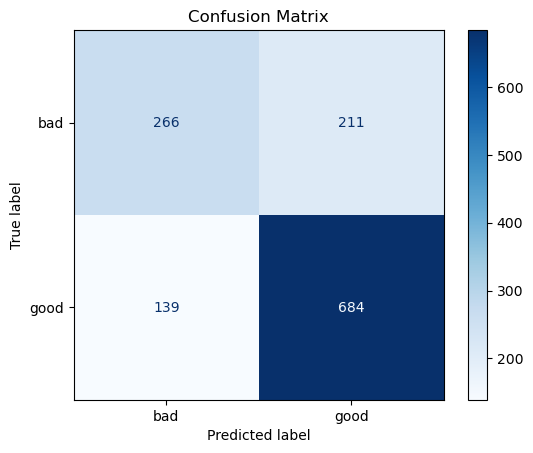

AUC: 0.7694

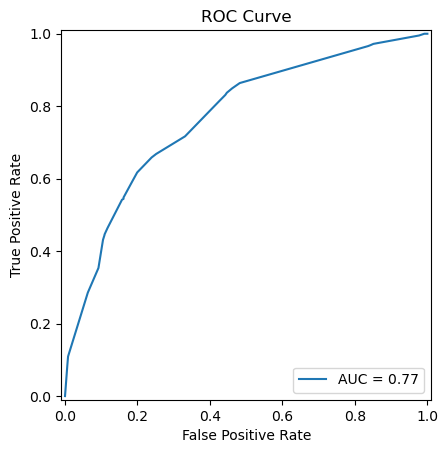

Feature order:
['pH', 'alcohol', 'sulphates']

In [164]:
preferred_features = ['pH', 'alcohol', 'sulphates']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["c"] = (met, cm)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### d) Unikanie atrybutów zawierających szum

Accuracy: 0.6892
F1 Score (macro): 0.6448
F1 Score (micro): 0.6892
Confusion Matrix:
      bad  good
bad   218   259
good  145   678

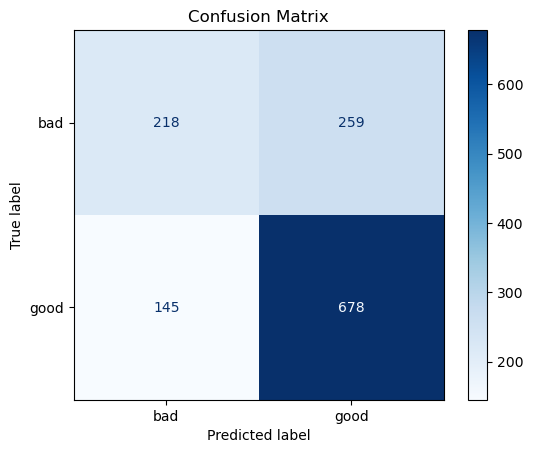

AUC: 0.7143

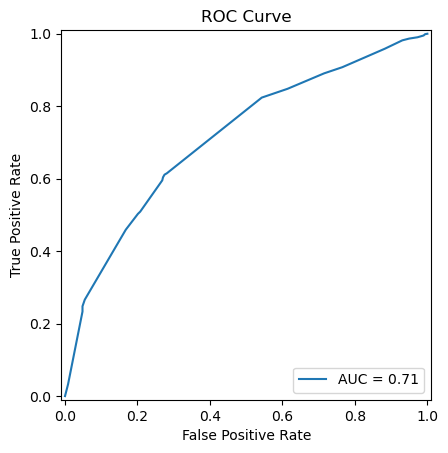

Feature order:
[
    'alcohol',
    'density',
    'volatile_acidity',
    'chlorides',
    'citric_acid',
    'total_sulfur_dioxide',
    'residual_sugar',
    'free_sulfur_dioxide',
    'sulphates'
]

In [165]:
threshold = 0.01
filtered_features = [(col, score) for col, score in feature_scores.items() if score > threshold]
feature_order = [X.columns.get_loc(col) for col, _ in sorted(filtered_features, key=lambda x: -x[1])]

clf_d = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met_d, cm_d = train_and_evaluate_model(clf_d, X.iloc[:, feature_order], y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["d"] = (met_d, cm_d)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### e) Preferencje na podstawie logicznej istotności

Accuracy: 0.7392
F1 Score (macro): 0.7218
F1 Score (micro): 0.7392
Confusion Matrix:
      bad  good
bad   318   159
good  180   643

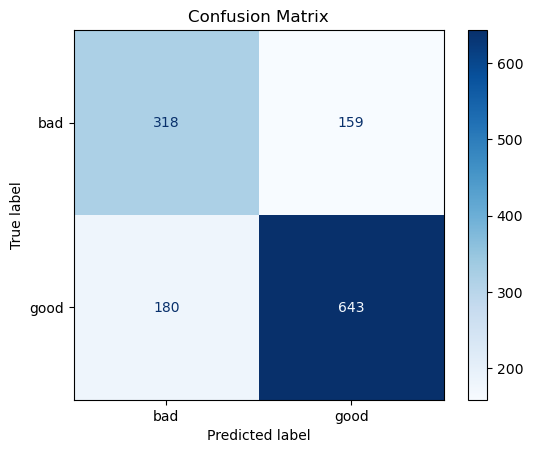

AUC: 0.7708

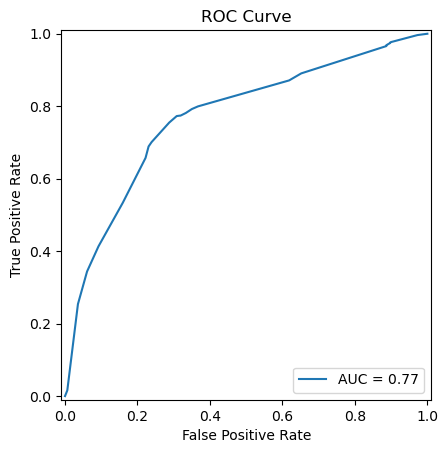

Feature order:
['alcohol', 'volatile_acidity', 'density']

In [166]:
preferred_features = ['alcohol', 'volatile_acidity', 'density']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["e"] = (met, cm)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### Porównanie podejść

In [167]:
rows = []
for key in metrics["Wine"]:
    scores, cm = metrics["Wine"][key]
    fn = cm.loc["good", "bad"]
    fp = cm.loc["bad", "good"]
    total_errors = fn + fp
    rows.append({
        "Experiment": key,
        "Accuracy": round(scores["accuracy"], 4),
        "F1 Macro": round(scores["f1_macro"], 4),
        "F1 Micro": round(scores["f1_micro"], 4),
        "Total errors (FP+FN)": total_errors
    })

df = pd.DataFrame(rows).sort_values(by="Experiment")
print(df.to_string(index=False))

Experiment  Accuracy  F1 Macro  F1 Micro  Total errors (FP+FN)
         0    0.7423    0.7228    0.7423                   335
         a    0.6954    0.6547    0.6954                   396
         b    0.7300    0.6938    0.7300                   351
         c    0.7308    0.6997    0.7308                   350
         d    0.6892    0.6448    0.6892                   404
         e    0.7392    0.7218    0.7392                   339

### Apartment for Rent Classified

In [168]:
apartment_for_rent_classified = fetch_ucirepo(id=555)
RANDOM_STATE = 3928

X = apartment_for_rent_classified.data.features
y = X.pop('price')

mask = ~y.isna()
X = X[mask]
y = y[mask]

for col in X.columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

price_median = y.median()
y_binary = (y >= price_median).astype(int)

metrics["Apartments"] = {}
X = X.sample(n=5000, random_state=RANDOM_STATE)
y_binary = y_binary[X.index]
X = X.copy()

c:\Users\Rafal\miniconda3\envs\SSNE\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
C:\Users\Rafal\AppData\Local\Temp\ipykernel_38308\1219572373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col].astype(str))
C:\Users\Rafal\AppData\Local\Temp\ipykernel_38308\1219572373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] 

#### 0) Podstawowy klasyfikator (brak preferencji)


Accuracy: 0.8670
F1 Score (macro): 0.8655
F1 Score (micro): 0.8670
Confusion Matrix:
           cheap  expensive
cheap        381         98
expensive     35        486

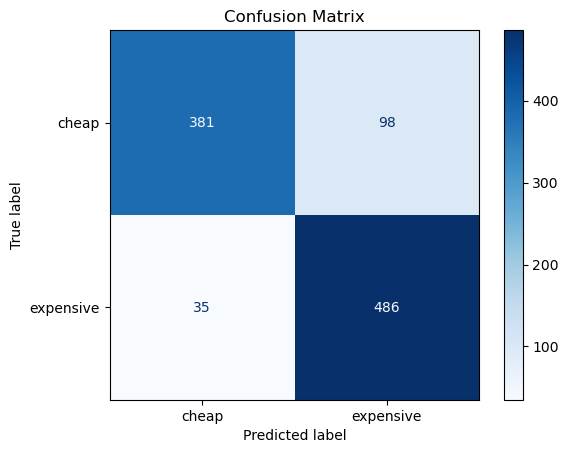

AUC: 0.9271

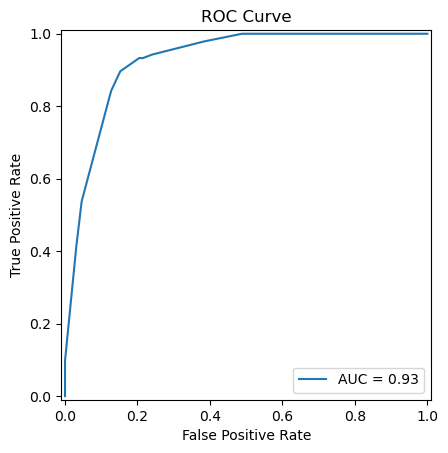

In [169]:
clf = CustomDecisionTreeClassifier(
    preference_list=[],
    similarity_threshold=0.0,
    max_depth=5,
    min_samples_split=5,
    class_names=["cheap", "expensive"]
)

met, cm = train_and_evaluate_model(
    clf, X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["cheap", "expensive"]
)

metrics["Apartments"]["0"] = (met, cm)

#### a) Preferowane atrybuty o niewielkiej liczbie wartości

Accuracy: 0.5570
F1 Score (macro): 0.5409
F1 Score (micro): 0.5570
Confusion Matrix:
           cheap  expensive
cheap        185        294
expensive    149        372

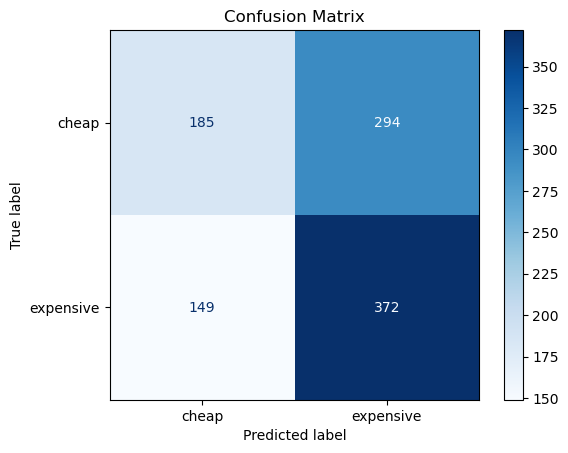

AUC: 0.5534

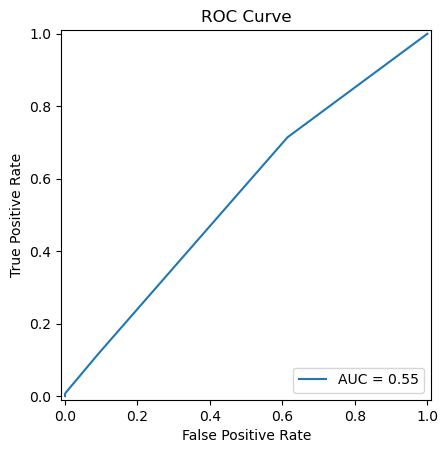

Feature order:
[
    'price_type',
    'currency',
    'fee',
    'category',
    'has_photo',
    'pets_allowed',
    'bathrooms',
    'source',
    'bedrooms',
    'state',
    'address',
    'cityname',
    'price_display',
    'square_feet',
    'amenities',
    'latitude',
    'longitude',
    'title',
    'time',
    'body'
]

In [170]:
feature_cardinality = X.nunique()
sorted_features = feature_cardinality.sort_values().index.tolist()
feature_order = [X.columns.get_loc(col) for col in sorted_features]

clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["cheap", "expensive"]
)
met, cm = train_and_evaluate_model(
    clf, X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["cheap", "expensive"]
)
metrics["Apartments"]["a"] = (met, cm)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### b) Preferowane atrybuty ustalone przez analizę danych

Accuracy: 0.8430
F1 Score (macro): 0.8428
F1 Score (micro): 0.8430
Confusion Matrix:
           cheap  expensive
cheap        406         73
expensive     84        437

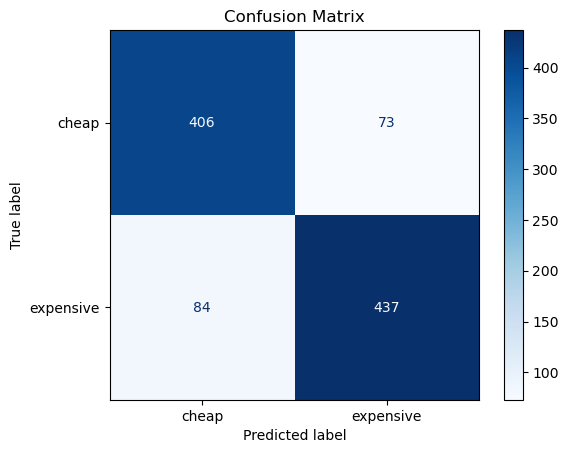

AUC: 0.8973

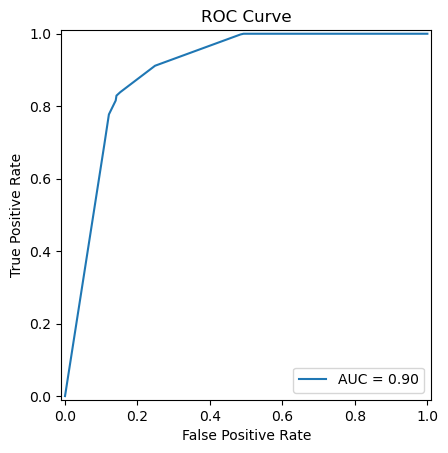

Feature order:
[
    'price_display',
    'longitude',
    'latitude',
    'cityname',
    'state',
    'title',
    'square_feet',
    'body',
    'amenities',
    'bathrooms',
    'bedrooms',
    'time',
    'pets_allowed',
    'currency',
    'source',
    'category',
    'fee',
    'has_photo',
    'price_type',
    'address'
]

In [171]:
mutual_info = mutual_info_classif(X, y_binary, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}
sorted_features = sorted(feature_scores.items(), key=lambda x: -x[1])
feature_order = [X.columns.get_loc(col) for col, _ in sorted_features]

clf_b = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["cheap", "expensive"]
)
met_b, cm_b = train_and_evaluate_model(
    clf_b, X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["cheap", "expensive"]
)
metrics["Apartments"]["b"] = (met_b, cm_b)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)


#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

Accuracy: 0.6900
F1 Score (macro): 0.6900
F1 Score (micro): 0.6900
Confusion Matrix:
           cheap  expensive
cheap        339        140
expensive    170        351

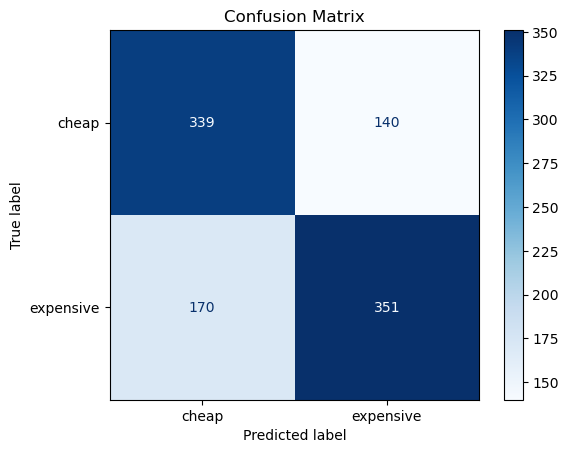

AUC: 0.7272

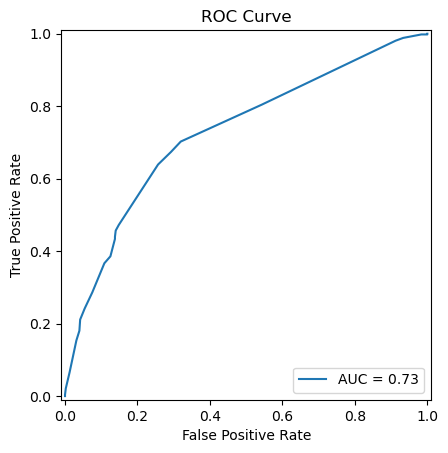

Feature order:
['bathrooms', 'bedrooms', 'square_feet', 'cityname', 'state']

In [172]:
preferred_features = ['bathrooms', 'bedrooms', 'square_feet', 'cityname', 'state']
feature_order = [X.columns.get_loc(col) for col in preferred_features]

clf_c = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["cheap", "expensive"]
)

met_c, cm_c = train_and_evaluate_model(
    clf_c, X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["cheap", "expensive"]
)

metrics["Apartments"]["c"] = (met_c, cm_c)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### d) Unikanie atrybutów zawierających szum

Accuracy: 0.7510
F1 Score (macro): 0.7500
F1 Score (micro): 0.7510
Confusion Matrix:
           cheap  expensive
cheap        344        135
expensive    114        407

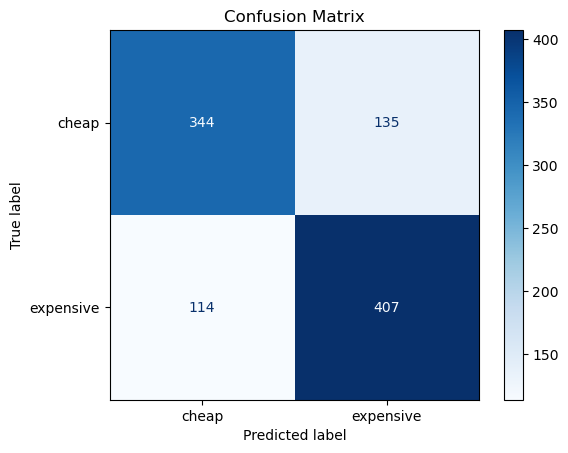

AUC: 0.8066

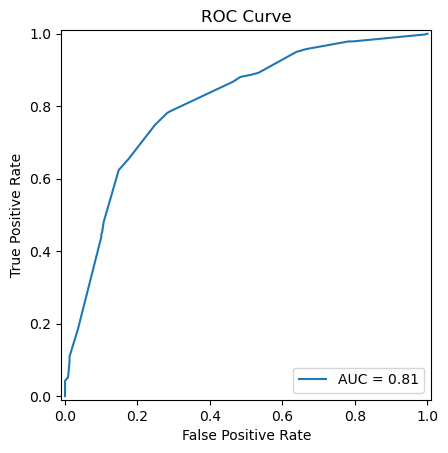

Feature order:
[
    'price_display',
    'longitude',
    'latitude',
    'cityname',
    'state',
    'title',
    'square_feet',
    'body',
    'amenities',
    'bathrooms',
    'bedrooms',
    'time'
]

In [173]:
threshold = 0.01
filtered_features = [(col, score) for col, score in feature_scores.items() if score > threshold]
feature_order = [X.columns.get_loc(col) for col, _ in sorted(filtered_features, key=lambda x: -x[1])]

clf_d = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["cheap", "expensive"]
)

met_d, cm_d = train_and_evaluate_model(
    clf_d, X.iloc[:, feature_order], y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["cheap", "expensive"]
)

metrics["Apartments"]["d"] = (met_d, cm_d)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### e) Preferencje na podstawie logicznej istotności

Accuracy: 0.7390
F1 Score (macro): 0.7346
F1 Score (micro): 0.7390
Confusion Matrix:
           cheap  expensive
cheap        305        174
expensive     87        434

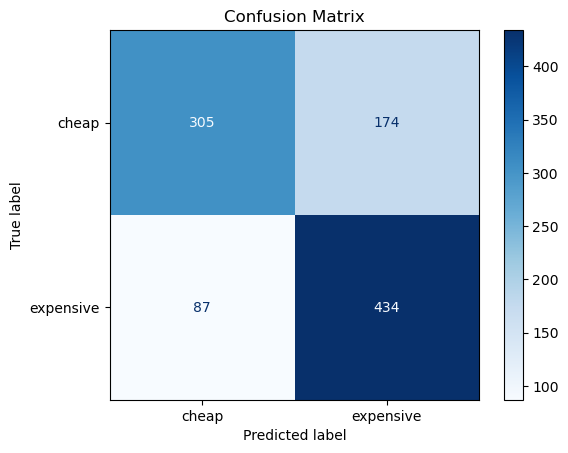

AUC: 0.7973

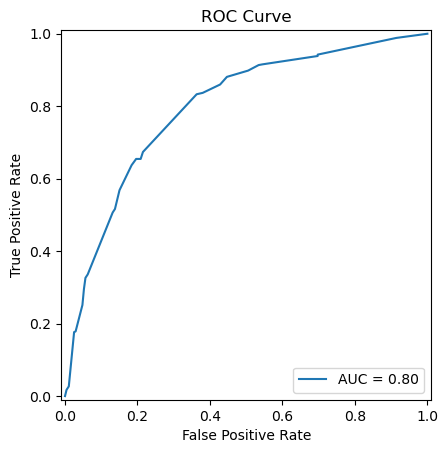

Feature order:
['square_feet', 'latitude', 'longitude', 'time', 'cityname', 'fee']

In [174]:
preferred_features = ['square_feet', 'latitude', 'longitude', 'time', 'cityname', 'fee']
feature_order = [X.columns.get_loc(col) for col in preferred_features]

clf_e = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["cheap", "expensive"]
)

met_e, cm_e = train_and_evaluate_model(
    clf_e, X, y_binary,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["cheap", "expensive"]
)

metrics["Apartments"]["e"] = (met_e, cm_e)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)


#### Porównanie podejść

In [175]:
rows = []
for key in metrics["Apartments"]:
    scores, cm = metrics["Apartments"][key]
    fn = cm.loc["expensive", "cheap"]
    fp = cm.loc["cheap", "expensive"]
    total_errors = fn + fp
    rows.append({
        "Experiment": key,
        "Accuracy": round(scores["accuracy"], 4),
        "F1 Macro": round(scores["f1_macro"], 4),
        "F1 Micro": round(scores["f1_micro"], 4),
        "Total errors (FP+FN)": total_errors
    })

df = pd.DataFrame(rows).sort_values(by="Experiment")
print(df.to_string(index=False))

Experiment  Accuracy  F1 Macro  F1 Micro  Total errors (FP+FN)
         0     0.867    0.8655     0.867                   133
         a     0.557    0.5409     0.557                   443
         b     0.843    0.8428     0.843                   157
         c     0.690    0.6900     0.690                   310
         d     0.751    0.7500     0.751                   249
         e     0.739    0.7346     0.739                   261

### Appliances Energy Prediction

In [176]:
RANDOM_STATE = 3928

appliances_energy_prediction = fetch_ucirepo(id=374)
X = appliances_energy_prediction.data.features
y = appliances_energy_prediction.data.targets

y = y.iloc[:, 0]
mask = ~y.isna()
X = X[mask]
y = y[mask]

for col in X.columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
X = X.copy()

median_value = y.median()
y = pd.cut(y, bins=[-float('inf'), median_value, float('inf')], labels=["low", "high"])

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 0 = low, 1 = high
metrics["Appliances"] = {}
X = X.sample(n=5000, random_state=RANDOM_STATE)
y = y_encoded[X.index]

#### 0) Podstawowy klasyfikator (brak preferencji)


Accuracy: 0.7160
F1 Score (macro): 0.7098
F1 Score (micro): 0.7160
Confusion Matrix:
      low  high
low   285   182
high  102   431

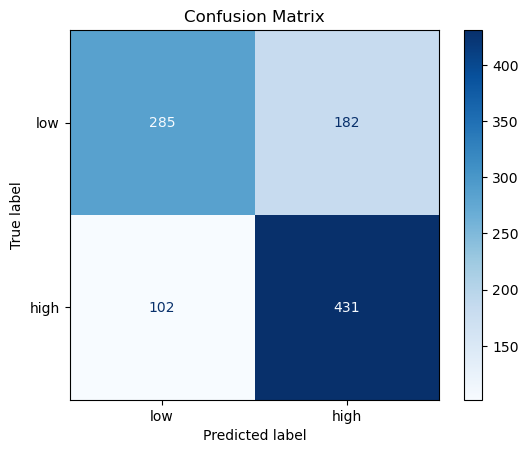

AUC: 0.7895

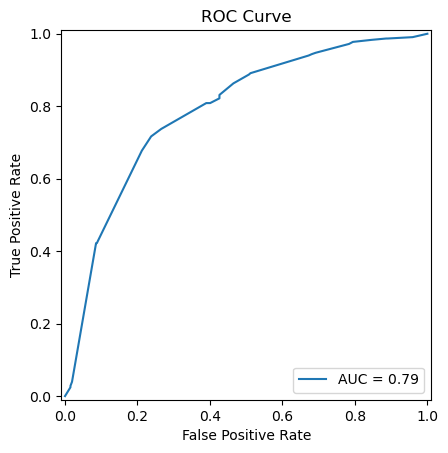

In [177]:
clf = CustomDecisionTreeClassifier(
    preference_list=[],
    similarity_threshold=0.0,
    max_depth=5,
    min_samples_split=5,
    class_names=["low", "high"]
)

met, cm = train_and_evaluate_model(
    clf, X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["low", "high"]
)

metrics["Appliances"]["0"] = (met, cm)

#### a) Preferowane atrybuty o niewielkiej liczbie wartości

Accuracy: 0.6920
F1 Score (macro): 0.6849
F1 Score (micro): 0.6920
Confusion Matrix:
      low  high
low   271   196
high  112   421

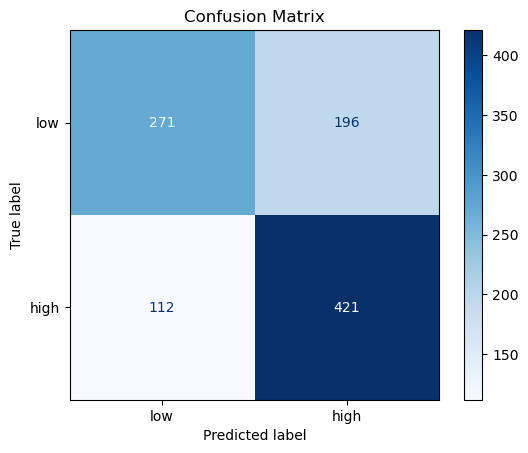

AUC: 0.7540

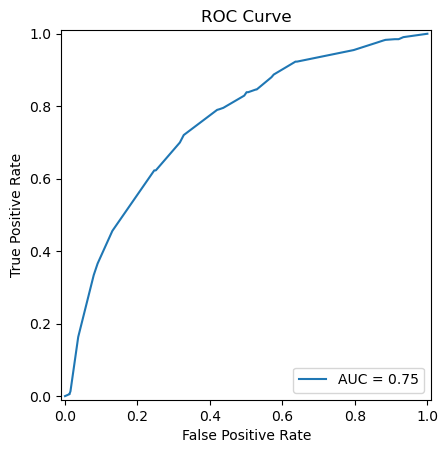

Feature order:
[
    'lights',
    'Windspeed',
    'Visibility',
    'T1',
    'RH_out',
    'T9',
    'T3',
    'T4',
    'T2',
    'T_out',
    'T7',
    'Tdewpoint',
    'T5',
    'T8',
    'RH_3',
    'RH_1',
    'RH_4',
    'Press_mm_hg',
    'RH_9',
    'RH_2',
    'T6',
    'RH_7',
    'RH_8',
    'RH_5',
    'RH_6',
    'date',
    'rv1',
    'rv2'
]

In [178]:
feature_cardinality = X.nunique()
sorted_features = feature_cardinality.sort_values().index.tolist()
feature_order = [X.columns.get_loc(col) for col in sorted_features]

clf_a = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["low", "high"]
)
met_a, cm_a = train_and_evaluate_model(
    clf_a, X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["low", "high"]
)
metrics["Appliances"]["a"] = (met_a, cm_a)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### b) Preferowane atrybuty ustalone przez analizę danych

Accuracy: 0.6560
F1 Score (macro): 0.6555
F1 Score (micro): 0.6560
Confusion Matrix:
      low  high
low   309   158
high  186   347

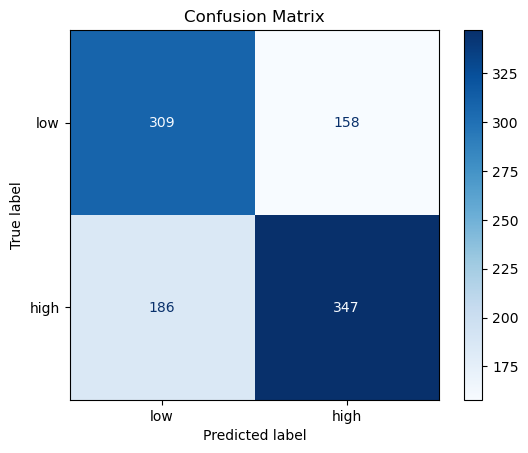

AUC: 0.7129

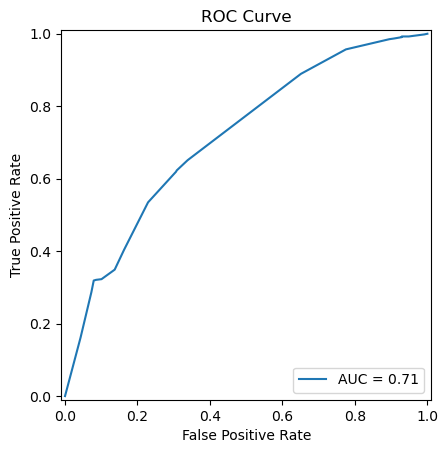

Feature order:
[
    'date',
    'RH_1',
    'T2',
    'RH_6',
    'T6',
    'RH_2',
    'T5',
    'T1',
    'T8',
    'RH_8',
    'T7',
    'T3',
    'lights',
    'T4',
    'RH_4',
    'RH_3',
    'RH_out',
    'RH_7',
    'T9',
    'T_out',
    'RH_5',
    'Press_mm_hg',
    'RH_9',
    'Tdewpoint',
    'Visibility',
    'Windspeed',
    'rv2',
    'rv1'
]

In [179]:
mutual_info = mutual_info_classif(X, y, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}
sorted_features_b = sorted(feature_scores.items(), key=lambda x: -x[1])
feature_order = [X.columns.get_loc(col) for col, _ in sorted_features_b]

clf_b = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["low", "high"]
)
met_b, cm_b = train_and_evaluate_model(
    clf_b, X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["low", "high"]
)
metrics["Appliances"]["b"] = (met_b, cm_b)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

Accuracy: 0.6880
F1 Score (macro): 0.6753
F1 Score (micro): 0.6880
Confusion Matrix:
      low  high
low   245   222
high   90   443

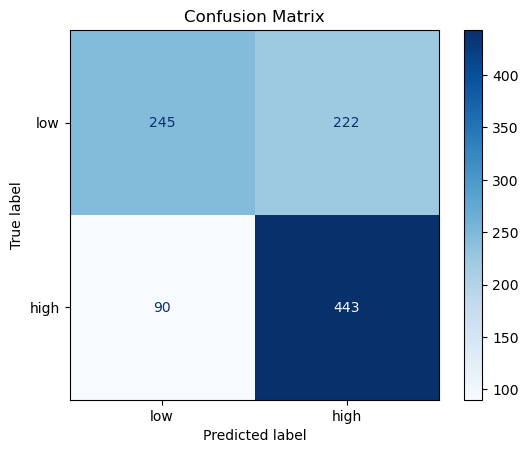

AUC: 0.7370

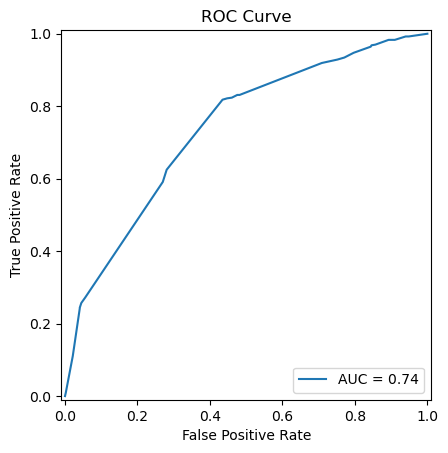

Feature order:
['T_out', 'RH_1', 'T1', 'lights']

In [180]:
preferred_features_c = ['T_out', 'RH_1', 'T1', 'lights']
feature_order = [X.columns.get_loc(col) for col in preferred_features_c if col in X.columns]

clf_c = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["low", "high"]
)
met_c, cm_c = train_and_evaluate_model(
    clf_c, X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["low", "high"]
)
metrics["Appliances"]["c"] = (met_c, cm_c)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### d) Unikanie atrybutów zawierających szum

Accuracy: 0.6800
F1 Score (macro): 0.6643
F1 Score (micro): 0.6800
Confusion Matrix:
      low  high
low   232   235
high   85   448

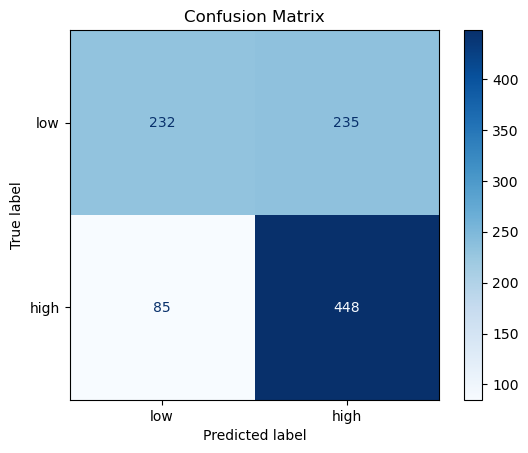

AUC: 0.7384

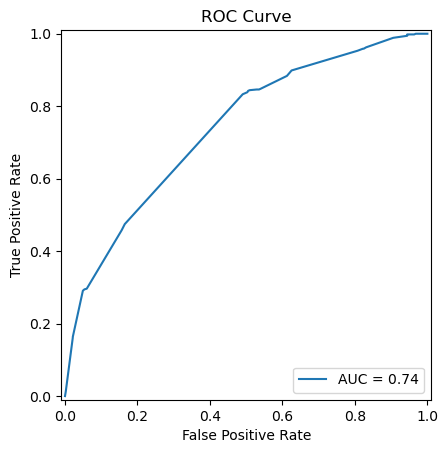

Feature order:
[
    'date',
    'RH_1',
    'T2',
    'RH_6',
    'T6',
    'RH_2',
    'T5',
    'T1',
    'T8',
    'RH_8',
    'T7',
    'T3',
    'lights',
    'T4',
    'RH_4',
    'RH_3',
    'RH_out',
    'RH_7',
    'T9',
    'T_out',
    'RH_5',
    'Press_mm_hg',
    'RH_9',
    'Tdewpoint',
    'Visibility',
    'Windspeed'
]

In [181]:
threshold = 0.01
filtered_features_d = [(col, score) for col, score in feature_scores.items() if score > threshold]
feature_order = [X.columns.get_loc(col) for col, _ in sorted(filtered_features_d, key=lambda x: -x[1])]

clf_d = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["low", "high"]
)
met_d, cm_d = train_and_evaluate_model(
    clf_d, X.iloc[:, feature_order], y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["low", "high"]
)
metrics["Appliances"]["d"] = (met_d, cm_d)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### e) Preferencje na podstawie logicznej istotności

Accuracy: 0.6950
F1 Score (macro): 0.6881
F1 Score (micro): 0.6950
Confusion Matrix:
      low  high
low   273   194
high  111   422

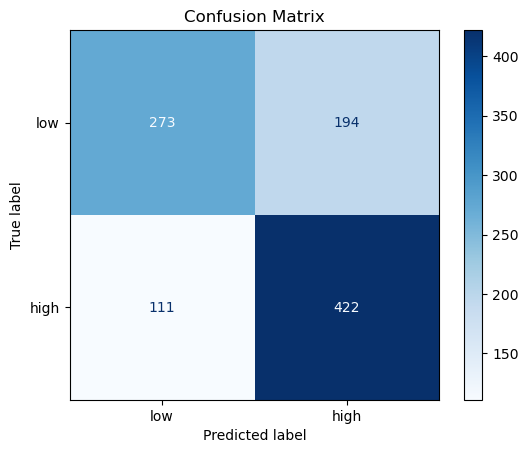

AUC: 0.7598

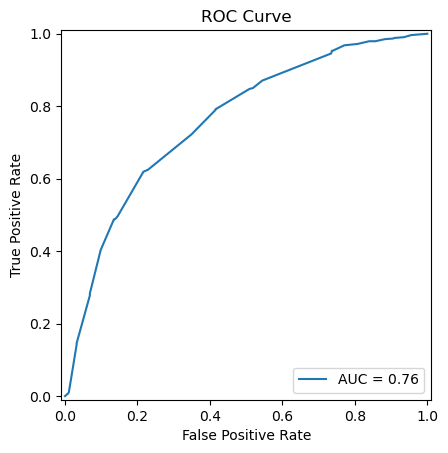

Feature order:
['T1', 'RH_1', 'T_out', 'lights']

In [182]:
preferred_features_e = ['T1', 'RH_1', 'T_out', 'lights']
feature_order = [X.columns.get_loc(col) for col in preferred_features_e if col in X.columns]

clf_e = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["low", "high"]
)
met_e, cm_e = train_and_evaluate_model(
    clf_e, X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    target_names=["low", "high"]
)
metrics["Appliances"]["e"] = (met_e, cm_e)
feature_names_in_order = [X.columns[i] for i in feature_order]
print("Feature order:", feature_names_in_order)

#### Porównanie podejść

In [183]:
rows = []
for key in metrics["Appliances"]:
    scores, cm = metrics["Appliances"][key]
    fn = cm.loc["high", "low"]
    fp = cm.loc["low", "high"]
    total_errors = fn + fp
    rows.append({
        "Experiment": key,
        "Accuracy": round(scores["accuracy"], 4),
        "F1 Macro": round(scores["f1_macro"], 4),
        "F1 Micro": round(scores["f1_micro"], 4),
        "Total errors (FP+FN)": total_errors
    })

df = pd.DataFrame(rows).sort_values(by="Experiment")
print(df.to_string(index=False))

Experiment  Accuracy  F1 Macro  F1 Micro  Total errors (FP+FN)
         0     0.716    0.7098     0.716                   284
         a     0.692    0.6849     0.692                   308
         b     0.656    0.6555     0.656                   344
         c     0.688    0.6753     0.688                   312
         d     0.680    0.6643     0.680                   320
         e     0.695    0.6881     0.695                   305

## Porównanie wszystkich podejść

In [184]:
rows = []
for dataset, experiments in metrics.items():
    for label, (scores, cm) in experiments.items():
        # Ustalenie nazw klas z macierzy
        classes = cm.columns.tolist()
        if len(classes) != 2:
            continue  # pomijamy błędne formaty
        
        actual_pos, actual_neg = classes[1], classes[0]
        fn = cm.loc[actual_pos, actual_neg]
        fp = cm.loc[actual_neg, actual_pos]
        total_errors = fn + fp

        rows.append({
            "Dataset": dataset,
            "Experiment": label,
            "Accuracy": round(scores["accuracy"], 4),
            "F1 Macro": round(scores["f1_macro"], 4),
            "F1 Micro": round(scores["f1_micro"], 4),
            "Total Errors (FP+FN)": int(total_errors)
        })

df_comparison = pd.DataFrame(rows).sort_values(by=["Dataset", "Experiment"])
print(df_comparison.to_string(index=False))


Dataset Experiment  Accuracy  F1 Macro  F1 Micro  Total Errors (FP+FN)
Apartments          0    0.8670    0.8655    0.8670                   133
Apartments          a    0.5570    0.5409    0.5570                   443
Apartments          b    0.8430    0.8428    0.8430                   157
Apartments          c    0.6900    0.6900    0.6900                   310
Apartments          d    0.7510    0.7500    0.7510                   249
Apartments          e    0.7390    0.7346    0.7390                   261
Appliances          0    0.7160    0.7098    0.7160                   284
Appliances          a    0.6920    0.6849    0.6920                   308
Appliances          b    0.6560    0.6555    0.6560                   344
Appliances          c    0.6880    0.6753    0.6880                   312
Appliances          d    0.6800    0.6643    0.6800                   320
Appliances          e    0.6950    0.6881    0.6950                   305
  Mushroom          0    1.0000    1.0000    1.0000                     0
  Mushroom          a    0.8917    0.8908    0.8917                   176
  Mushroom          b    0.9938    0.9938    0.9938                    10
  Mushroom          c    0.9914    0.9914    0.9914                    14
  Mushroom          d    0.9065    0.9064    0.9065                   152
  Mushroom          e    0.9969    0.9969    0.9969                     5
      Wine          0    0.7423    0.7228    0.7423                   335
      Wine          a    0.6954    0.6547    0.6954                   396
      Wine          b    0.7300    0.6938    0.7300                   351
      Wine          c    0.7308    0.6997    0.7308                   350
      Wine          d    0.6892    0.6448    0.6892                   404
      Wine          e    0.7392    0.7218    0.7392                   339

## Wnioski

### Opis podejść

| Podejście | Opis                                                                                      |
|-----------|---------------------------------------------------------------------------------------------|
| `0`       | **Model bazowy** — brak preferencji atrybutów    |
| `a`       | **Preferencja atrybutów o niskiej liczbie unikalnych wartości**   |
| `b`       | **Preferencja na podstawie wzajemnej informacji (mutual information)** |
| `c`       | **Preferencje oparte na koszcie pozyskania danych** |
| `d`       | **Unikanie atrybutów o niskiej wartości informacyjnej**         |
| `e`       | **Preferencje logiczne** – wybór cech istotnych według wiedzy domenowej     |

---

### Wnioski ogólne:

1. **Podejście `0` (bazowe)** osiąga najlepsze lub jedne z najlepszych wyników w większości zbiorów, szczególnie:
   - Mushroom: 100% Accuracy, 0 błędów
   - Apartments: 86.7% Accuracy
   - Appliances: 71.6% Accuracy

2. **Podejście `a`** jest wyraźnie najsłabsze:
   - Najniższe accuracy i F1 we wszystkich zbiorach
   - Najwięcej błędów (np. 443 w Apartments)

3. **Podejścia `b`, `c`, `e`** są bardziej konkurencyjne:
   - Często dorównują lub przewyższają `0` (np. `e` w Mushroom – tylko 5 błędów, 99.69% Accuracy)
   - Stabilnie poprawiają wyniki względem `a` i `d`

4. **Podejście `d`** wypada niestabilnie:
   - W niektórych przypadkach lepsze niż `a`, ale generalnie gorsze od `b`, `c`, `e`

---

### Wnioski dla poszczególnych zbiorów:

#### Mushroom
- **Najlepsze podejście:** `0` (Accuracy: 1.0000, błędy: 0)
- **Najgorsze:** `a` (Accuracy: 0.8917, błędy: 176)
- Dane są łatwe do klasyfikacji – większość modeli radzi sobie doskonale

#### Apartments
- **Najlepsze:** `0` (Accuracy: 0.8670, błędy: 133)
- **Dobre:** `b` (0.8430) i `d` (0.7510)
- **Najgorsze:** `a` (0.5570, błędy: 443)

#### Wine
- **Najlepsze:** `0` (Accuracy: 0.7423), `e` (0.7392)
- **Najgorsze:** `a` i `d` (~0.69 Accuracy, ~400 błędów)
- Różnice między podejściami są mniejsze niż w innych zbiorach

#### Appliances
- **Najlepsze:** `0` (0.7160 Accuracy, 284 błędów), `e` (0.6950, 305 błędów)
- **Najgorsze:** `b` (0.6560 Accuracy, 344 błędów)
- Zbiór jest trudniejszy, ale `0` i `e` radzą sobie najlepiej

---

### Ranking:

| Podejście | Ogólna skuteczność | Komentarz |
|-----------|--------------------|-----------|
| `0`       | 🟢 Najlepsze lub bardzo dobre | Stabilne, silna baza |
| `a`       | 🔴 Najsłabsze       | Najwięcej błędów, najniższe metryki |
| `b`       | 🟡 Dobre             | Często konkurencyjne |
| `c`       | 🟡 Dobre             | Porównywalne z `b` |
| `d`       | 🟠 Średnie           | Niestabilne |
| `e`       | 🟢 Bardzo dobre      | Wysokie accuracy, niska liczba błędów |
